# Example notebook for loading nanosurf AFM data through the NSFopen package:

In [ ]:
# !pip install NSFopen  # Must run this once per session & restart kernel afterwards

In [1]:
# Imports
import pathlib
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
from NSFopen.read import read as afmreader

In [2]:
# Copied example functions for plane fitting & median search:

def fit2DPlane(matrix, xaxis, yaxis):
    m = len(xaxis)
    X1, Y1 = np.meshgrid(xaxis, yaxis)
    X = np.hstack(( np.reshape(X1, (m*m, 1)) , np.reshape(Y1, (m*m, 1)) ))
    X = np.hstack(( np.ones((m*m, 1)) , X ))
    YY = np.reshape(matrix, (m*m, 1))

    theta = np.dot(np.dot( np.linalg.pinv(np.dot(X.transpose(), X)), X.transpose()), YY)
    plane = np.reshape(np.dot(X, theta), (m, m))
    
    return plane

def findLimits(matrix, strength):
    array1D = matrix.flatten()
    mean = np.mean(array1D)
    stdev = np.std(array1D)
    armin = mean - strength/2*stdev
    armax = mean + strength/2*stdev
    return armin, armax

In [6]:
# Define paths

# rootPath = pathlib.Path('/nsls2/users/alevin/rsoxs_suite')
suitePath = pathlib.Path.cwd().parent
afmsPath = suitePath.joinpath('afm_data/SST1_2023C2')
dataPath = afmsPath.joinpath('2023-07-24')

In [7]:
afms_list = sorted(dataPath.glob('*'))
afms_list

[PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/rsoxs_suite/afm_data/SST1_2023C2/2023-07-24/levin_AlO-test.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/rsoxs_suite/afm_data/SST1_2023C2/2023-07-24/levin_AlOp1_00823.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/rsoxs_suite/afm_data/SST1_2023C2/2023-07-24/levin_AlOp1_00824.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/rsoxs_suite/afm_data/SST1_2023C2/2023-07-24/levin_AlOp1_00825.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/rsoxs_suite/afm_data/SST1_2023C2/2023-07-24/levin_AlOp1_00826.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/rsoxs_suite/afm_data/SST1_2023C2/2023-07-24/levin_AlOp2_00827.nid'),
 PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O

In [9]:
sorted(dataPath.glob('*840*'))[0]

PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/rsoxs_suite/afm_data/SST1_2023C2/2023-07-24/levin_PM6p1_00840.nid')

In [8]:
afm_obj = afmreader(sorted(dataPath.glob('*840*'))[0])

Reading Header
Reading Data
Elapsed Time: 0.13 sec



In [19]:
data = afm_obj.data['Image']['Forward']['Z-Axis'].astype(float)
param = afm_obj.param
data.shape

(512, 512)

In [20]:
xrange = param['X']['range'][0]*1e9  # Convert m to nm
yrange = param['Y']['range'][0]*1e9  # Convert m to nm
print(f'({xrange}, {yrange})')

xaxis = np.linspace(0, xrange, len(data[0]))
yaxis = np.linspace(0, yrange, len(data[1]))

(700.0, 700.0)


In [36]:
plane = fit2DPlane(data, xaxis, yaxis)
data_levelled = data - plane
data_levelled = data_levelled[80:-80, 80:-80]
data_levelled = data_levelled + np.abs(np.min(data_levelled))

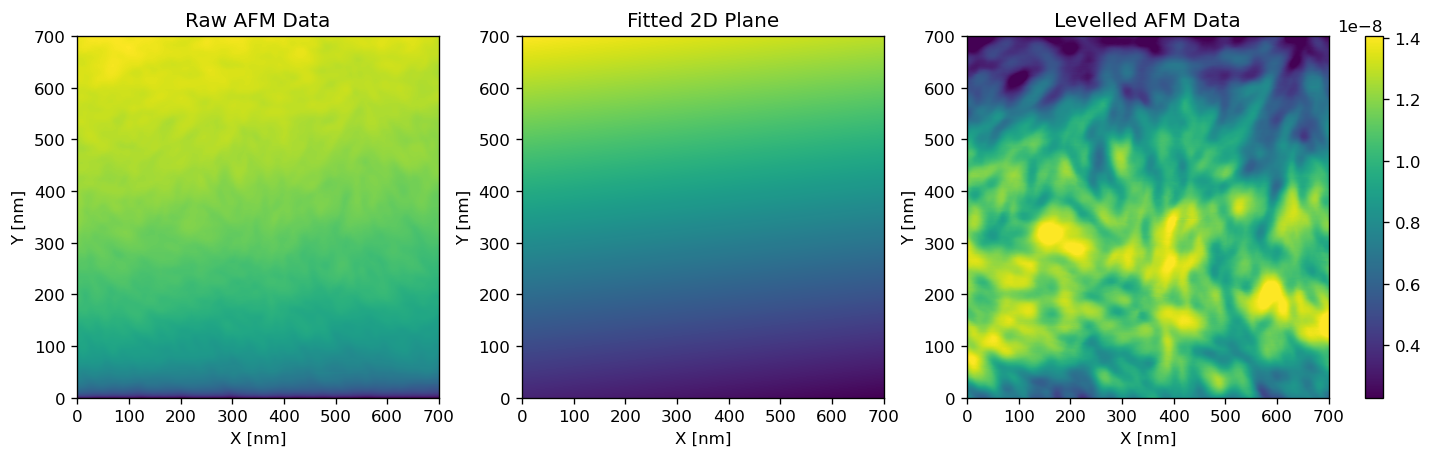

In [37]:
#Plot 
cmin = np.percentile(data_levelled, 1)
cmax = np.percentile(data_levelled, 99)

fig, axs = plt.subplots(1,3)
fig.set(tight_layout=True, size_inches=(12, 4), dpi=120)
axs[0].imshow(data, origin='lower', extent=[0, xrange, 0, yrange])
axs[0].set_title('Raw AFM Data')
axs[1].imshow(plane, origin='lower', extent=[0, xrange, 0, yrange])
axs[1].set_title('Fitted 2D Plane')
axs[2].imshow(data_levelled, origin='lower', extent=[0, xrange, 0, yrange], vmin=cmin, vmax=cmax)
axs[2].set_title('Levelled AFM Data')
# axs[2].set(xlim=([100,600]), ylim=([100,600]))

for ax in axs:
    ax.set(xlabel='X [nm]', ylabel='Y [nm]')

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(cmin, cmax))
cax = axs[2].inset_axes([1.1, 0, 0.05, 1])
fig.colorbar(sm, cax=cax)

plt.show()